# Оптимизация маркетинговых затрат в Яндекс.Афише

## Описание проекта:

Анализ данных от Яндекс.Афиши с целью оптимизации маркетинговых затрат.
Расчет метрик LTV, CAC, Retention rate, DAU, WAU, MAU, ROMI

## План проекта:

1. Загрузка данных и подготовка их к анализу.   
2. Расчет метрик, характеризующих продукт.    
2.1. Расчет DAU, WAU, MAU.   
2.2. Расчет длительности и количества сессий.   
2.3. Расчет Retention Rate.   
3. Расчет метрик, характеризующих продажи.   
3.1. Расчет времени до первой покупки.    
3.2. Расчет количества покупок за период.   
3.3. Расчет среднего чека за месяц.   
3.4. Расчет LTV по когортам.   
4. Расчет метрик, характеризующих маркетинг.   
4.1. Расчет ROI.   
4.2. Расчет затрат по источникам привлечения и периодам.   
4.3. Расчет LTV, CAC, ROI и количества привлеченных пользователей для каждого источника.   
4.4. Расчет LTV и количества привлеченных пользователей для каждого вида устройств.    
5. Вывод.

## 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

Загрузим данные.

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [4]:
costs = pd.read_csv('/datasets/costs.csv')

Изучим данные и подготовим их к анализу.

In [5]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица visits содержит данные о визитах пользователей. В таблице 5 столбцов и 359400 строк. Пропущенных данных нет. Тип данных, содержащихся в End Ts и Start Ts необходимо поменять с object на datetime. Тип данных столбца uid - uint64, тип целых чисел размеров 8 байт, подходит для целей анализа. Названия столбцов таблицы необходимо исправить - привести к нижнему регистру и убрать пробелы.

Исправим названия столбцов.

In [7]:
visits.columns = ['device', 'end_ts', 'sourse_id', 'start_ts', 'uid']

In [8]:
visits.head()

,device,end_ts,sourse_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Заменим тип данных в столбцах end_ts и start_ts на datetime.

In [9]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [10]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
sourse_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [12]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица orders содержит данные о заказах пользователей. В таблице 3 столбца и 50415 строк. Пропущенных данных нет. Тип данных, содержащихся в Buy Ts необходимо поменять с object на datetime. Тип данных столбца uid - uint64, тип целых чисел размеров 8 байт, подходит для целей анализа. Названия столбцов таблицы необходимо исправить - привести к нижнему регистру и убрать пробелы.

Исправим названия столбцов.

In [14]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [15]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Заменим тип данных в столбцу buy_ts на datetime.

In [16]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [18]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица costs содержит данные о затратах на маркетинг. В таблице 3 столбца и 2542 строки. Пропущенных данных нет. Тип данных, содержащихся в dt необходимо поменять с object на datetime. 

In [20]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [21]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


## 2. Расчет метрик, характеризующих продукт.

### 2.1. Расчет DAU, WAU, MAU.

Посчитаем количество людей, пользующихся продуктом в день, неделю, месяц. Рассчитаем средние значения DAU, WAU и MAU за весь анализируемый срок.

In [22]:
visits['date'] = visits['start_ts'].dt.date

In [23]:
visits['week'] = visits['start_ts'].astype('datetime64[W]')

In [24]:
visits['month'] = visits['start_ts'].astype('datetime64[M]')

In [25]:
visits['year'] = visits['start_ts'].dt.year

Посчитаем количество уникальных пользователей в день за весь период.

In [26]:
dau_total = visits.groupby('date').agg({'uid':'nunique'}).mean()
print(int(dau_total))

907


Посчитаем количество уникальных пользователей в неделю за весь период.

In [27]:
wau_total = visits.groupby('week').agg({'uid':'nunique'}).mean()
print(int(wau_total))

5724


Посчитаем количество уникальных пользователей в месяц за весь период.

In [28]:
mau_total = visits.groupby('month').agg({'uid':'nunique'}).mean()
print(int(mau_total))

23228


Рассчитаем MAU, представим данные в виде графика.

In [29]:
mau = visits.groupby(['month']).agg({'uid':'nunique'}).reset_index()
mau

,month,uid
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692
5,2017-11-01,32797
6,2017-12-01,31557
7,2018-01-01,28716
8,2018-02-01,28749
9,2018-03-01,27473


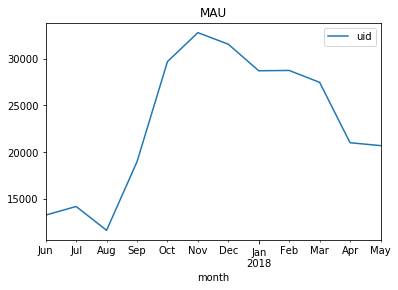

In [30]:
mau.plot(y='uid', x='month', title='MAU')

По виду графика можно сделать вывод о том, что в период с августа по ноябрь 2017 наблюдался ежемесячный рост количества уникальных пользователей. С декабря по май 2018 происходило снижение рассматриваемого показателя. 

Рассчитаем WAU, представим данные в виде графика.

In [31]:
wau = visits.groupby(['week']).agg({'uid':'nunique'}).reset_index()

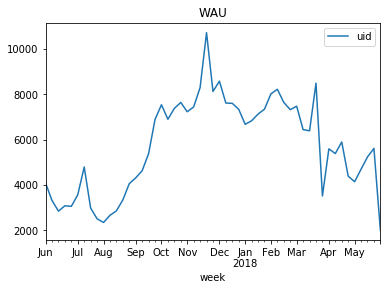

In [32]:
wau.plot(y='uid', x='week', title='WAU')

Недельный график показывает ту же картину, что и месчный - рост с августа по ноябрь 2017 и падение с декабря по май 2018 года. В дальнейшем для анализа будем использовать месячный масштаб. 

Расссчитаем среднее количество сессий в день за весь анализируемый период.

In [33]:
n_session_total = visits.groupby('date').agg({'uid':'count'}).mean()
print(int(n_session_total))

987


### 2.2. Расчет длительности и количества сессий.

In [34]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Определим количество сессий протяженностью 0 секунд.

In [35]:
visits[visits ['session_duration'] == 0]['session_duration'].count()

35794

Посчитаем количество ненулевых сессий для каждого месяца. Построим график.

In [36]:
n_session_month = visits.query('session_duration != 0').groupby('month').agg({'uid':'count'}).reset_index()

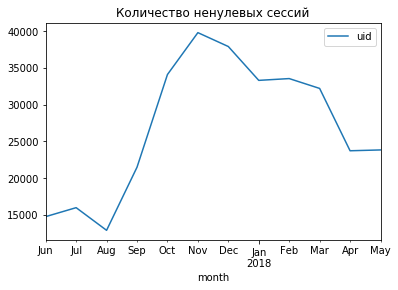

In [37]:
n_session_month.plot(y='uid', x='month', title='Количество ненулевых сессий')

Посмотрим на вид распределения длительности сессии.

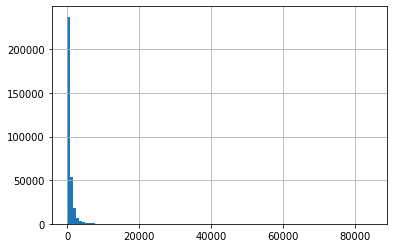

In [38]:
visits[visits ['session_duration'] != 0]['session_duration'].hist(bins=100)

Распределение длительности сессий не является нормальным. Поэтому определим для анализируемого периода моду длительности сессии.

In [39]:
session_duration_mode = visits['session_duration'].mode()
session_duration_mode

0    60
dtype: int64

Определим среднее значение длительности сессии для каждого месяца, входящего в анализируемый период. Построим график. 

In [40]:
session_duration_month = visits.query('session_duration != 0').groupby('month')['session_duration'].mean()
session_duration_month

month
2017-06-01    670.326113
2017-07-01    674.010817
2017-08-01    654.928981
2017-09-01    664.295180
2017-10-01    683.076693
2017-11-01    788.235180
2017-12-01    769.355677
2018-01-01    724.272430
2018-02-01    715.031060
2018-03-01    732.593902
2018-04-01    671.223505
2018-05-01    687.939060
Name: session_duration, dtype: float64

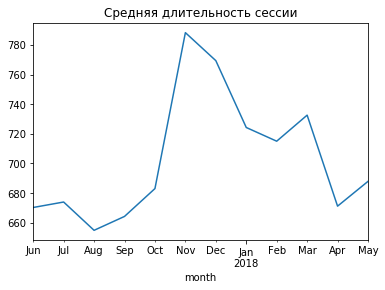

In [41]:
session_duration_month.plot(title='Средняя длительность сессии')

По виду графика можно сделать вывод о том, что средняя длительность сессии росла с сентября до ноября 2017 года, с декабря по май 2018 наблюдалось падение средней длительности сессии.  

Определим медианное значение длительности сессии для каждого месяца, входящего в анализируемый период. Построим график.

In [42]:
visits.head()

,device,end_ts,sourse_id,start_ts,uid,date,week,month,year,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017,0


In [43]:
session_median = visits.query('session_duration != 0').groupby('month')['session_duration'].median()
session_median

month
2017-06-01    360
2017-07-01    360
2017-08-01    300
2017-09-01    360
2017-10-01    360
2017-11-01    360
2017-12-01    360
2018-01-01    360
2018-02-01    360
2018-03-01    360
2018-04-01    360
2018-05-01    360
Name: session_duration, dtype: int64

### 2.3. Расчет Retention Rate.

Рассчитаем Retention Rate. Разобьем пользователей на когорты в зависимости от месяца первого посещения. Определим дату первого посещения.

In [45]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()

In [46]:
first_activity_date.name = 'first_activity_date'

Добавим в visits дату первого посещения каждого пользователя.

In [47]:
visits = visits.join(first_activity_date,on='uid')

Определим месяц первого посещения и месяц активности пользователя.

In [48]:
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

In [49]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

Добавим в visits данные о времени жизни когорты.

In [50]:
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month'])/np.timedelta64(1,'M') 

In [51]:
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Посчитаем количество уникальных пользователей на каждоим этапе времени жизни когорты.

In [52]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Посчитаем количество уникальных пользователей на нулевом этапе жизни когорты.

In [53]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [54]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Добавим данные о количестве пользователей на нулевом этапе в таблицу cohorts/.

In [55]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')

Посчитаем retention как отношение количества пользователей на каждоим этапе к количеству пользователей на нулевом этапе.

In [56]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

Посторим сводную таблицу с данными retention я каждой когорты на каждом этапе жизни когорты.

In [57]:
retention_pivot = (cohorts.pivot_table
                  (index='first_activity_month', columns='cohort_lifetime', values='retention', aggfunc='sum'))
retention_pivot.fillna(' ')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


Построим тепловую карту для данных о retention в процентах.

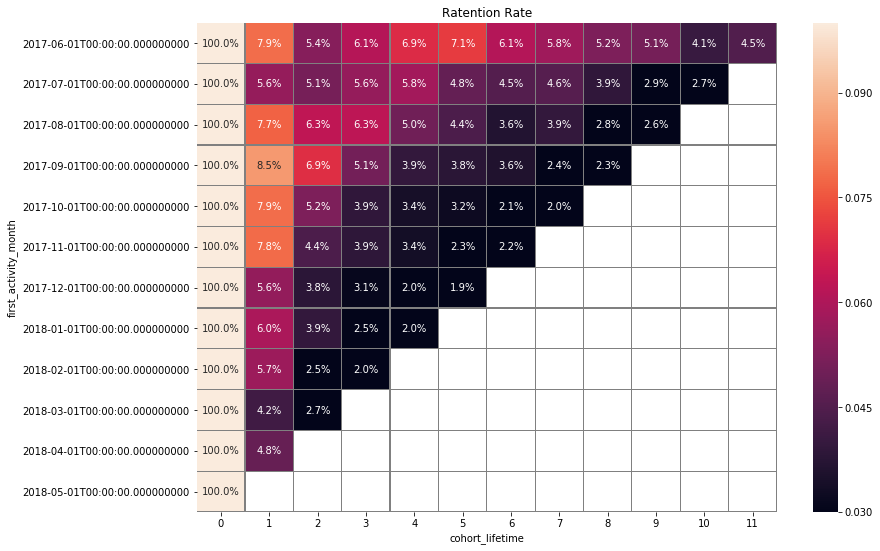

In [58]:
plt.figure(figsize=(13,9))
plt.title('Ratention Rate')
sns.heatmap(retention_pivot, annot=True,fmt='.1%', linewidths=.1, linecolor='grey', vmin=0.03, vmax=0.1)

По виду тепловой карты можно сделать вывод о том, что наиболее высокие коэффициенты удержания демонстрируют летние когорты, что можно попытаться объяснить сезонностью - пользователи, пришедшие в начале летнего сезона продолжают покупать на протяжении всего сезона.  

## 3. Расчет метрик, характеризующих продажи.

### 3.1. Расчет времени до первой покупки.

Установим когда люди начинают покупать. Узнаем дату первой покупки для каждого пользователя.

In [59]:
first_order = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()

In [60]:
first_order.columns = ['uid','first_order']

In [61]:
first_order

,uid,first_order
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


Установим месяц первой покупки.

In [62]:
first_order['first_order_month'] = first_order['first_order'].astype('datetime64[M]')

Добавим данные о первой покупке в visits.

In [63]:
visits = visits.merge(first_order, on='uid')

Рассчитаем время до покупки как разность между датой первой покупки и датой первого визита.

In [64]:
visits['time_to_order'] = visits['first_order'] - visits['first_activity_date']

In [65]:
visits.head()

,device,end_ts,sourse_id,start_ts,uid,date,week,month,year,session_duration,first_activity_date,activity_month,first_activity_month,cohort_lifetime,first_order,first_order_month,time_to_order
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2018-03-01,00:20:00
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,2018,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2018-03-01,00:20:00
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-31,2017-09-01,2017,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2017-09-01,15:11:00
3,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-27,2017-10-26,2017-10-01,2017,2520,2017-09-03 21:35:00,2017-10-01,2017-09-01,1,2017-09-04 12:46:00,2017-09-01,15:11:00
4,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-04,2017-08-31,2017-09-01,2017,1140,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2017-09-01,15:11:00


Переведем данные о времени до покупки из типа timedelta в секунды.

In [66]:
visits['time_to_order'] = visits['time_to_order'].dt.total_seconds()

Посчитаем время до первой покупки в часах.

In [67]:
visits['time_to_order_hours'] = visits['time_to_order']/3600

Рассчитаем среднее время до первой покупки в часах. 

In [68]:
visits['time_to_order_hours'].mean()

809.4201468605185

В среднем от первого визита до первой покупки проходит 33 дня. 

### 3.2. Расчет количества покупок за период.

Узнаем как распределялись даты продаж, узнаем первую и последнюю даты анализируемого периода.

In [69]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Узнаем какое количество покупок было сделано в каждом месяце периода.

In [70]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [71]:
number_per_month = orders.pivot_table(index='buy_month', values='buy_ts', aggfunc='count').reset_index()
number_per_month.columns = ['buy_month', 'number_per_month']
number_per_month

,buy_month,number_per_month
0,2017-06-01,2354
1,2017-07-01,2363
2,2017-08-01,1807
3,2017-09-01,3387
4,2017-10-01,5679
5,2017-11-01,5659
6,2017-12-01,6218
7,2018-01-01,4721
8,2018-02-01,5281
9,2018-03-01,5326


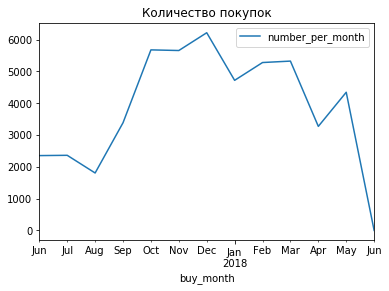

In [72]:
number_per_month.plot(y='number_per_month', x='buy_month', title='Количество покупок')

Узнаем зависит ли количество покупок от месяца первой покупки. Разобъем покупателей на когорты в зависимости от месяца первой покупки.

In [73]:
first_order_date = orders.groupby(['uid'])['buy_ts'].min()

In [74]:
first_order_date.name = 'first_order_date'

In [75]:
orders = orders.join(first_order_date, on='uid')

In [76]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [77]:
orders['cohort_lifetime'] = (orders['buy_month'] - orders['first_order_month'])/np.timedelta64(1,'M') 

In [78]:
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

In [79]:
buy_cohorts = orders.groupby(['first_order_month', 'cohort_lifetime']).agg({'uid':'count'}).reset_index()

In [80]:
orders_number_pivot = (buy_cohorts.pivot_table
                  (index='cohort_lifetime', columns='first_order_month', values='uid', aggfunc='sum'))
orders_number_pivot.fillna(' ')

first_order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
cohort_lifetime,,,,,,,,,,,,,
0,2354.0,2186,1533,2933,4964,4813,5052,3783,4095,4130,2495,3249,1
1,177.0,100,108,219,314,397,270,224,222,178,195,,
2,174.0,120,100,161,162,182,202,159,83,176,,,
3,226.0,104,81,164,122,211,179,64,70,,,,
4,292.0,72,85,67,129,136,86,78,,,,,
5,218.0,82,62,109,103,59,105,,,,,,
6,276.0,61,49,108,86,102,,,,,,,
7,174.0,50,78,56,125,,,,,,,,
8,212.0,58,46,61,,,,,,,,,


Построим график по данным orders_number_pivot. 

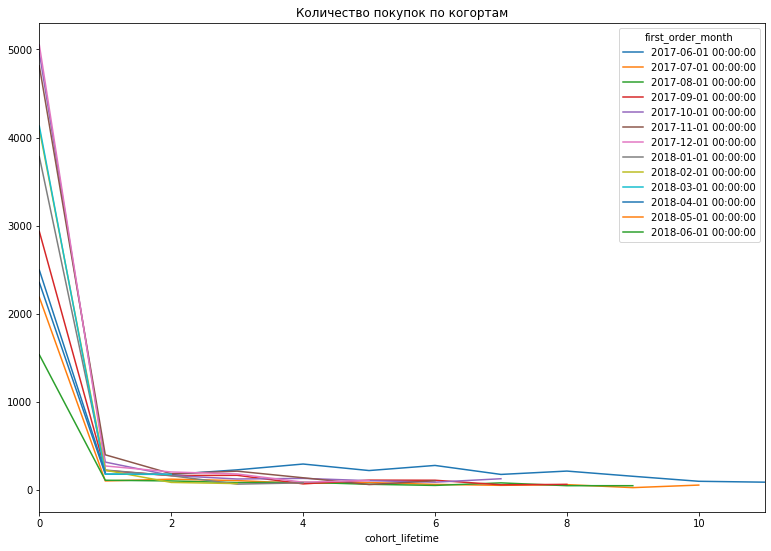

In [81]:
orders_number_pivot.plot(figsize=(13,9), title='Количество покупок по когортам')

### 3.3. Расчет среднего чека за месяц.

In [82]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Узнаем количество нулевых покупок.

In [83]:
orders.query('revenue == 0')['revenue'].count()

51

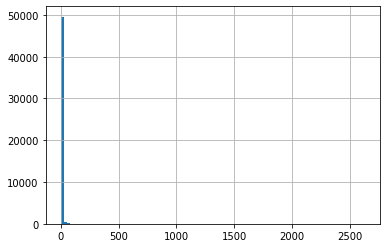

In [84]:
orders.query('revenue >0')['revenue'].hist(bins=100)

Распределение выручки отличается от нормального. Посмотрим на среднее и медиану. 

In [85]:
meancheque_month = orders.groupby('buy_month')['revenue'].mean()
meancheque_month

buy_month
2017-06-01    4.060106
2017-07-01    5.306589
2017-08-01    4.847139
2017-09-01    5.416448
2017-10-01    4.928280
2017-11-01    4.783518
2017-12-01    5.852139
2018-01-01    4.112927
2018-02-01    4.840095
2018-03-01    5.413930
2018-04-01    5.150645
2018-05-01    4.771279
2018-06-01    3.420000
Name: revenue, dtype: float64

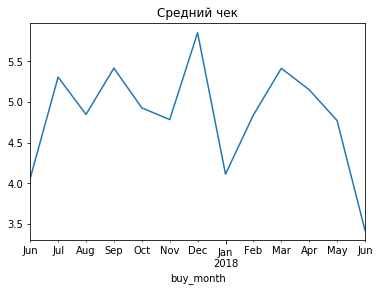

In [86]:
meancheque_month.plot(title='Средний чек')

In [87]:
mediancheque_month = orders.groupby('buy_month')['revenue'].median()
mediancheque_month

buy_month
2017-06-01    2.44
2017-07-01    3.05
2017-08-01    2.78
2017-09-01    2.44
2017-10-01    2.44
2017-11-01    2.44
2017-12-01    2.69
2018-01-01    2.44
2018-02-01    2.69
2018-03-01    2.44
2018-04-01    2.75
2018-05-01    2.44
2018-06-01    3.42
Name: revenue, dtype: float64

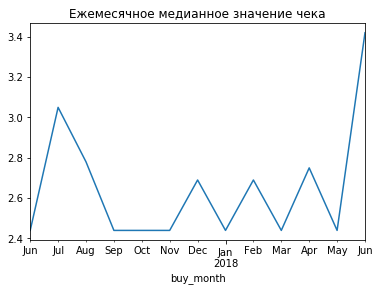

In [88]:
mediancheque_month.plot(title='Ежемесячное медианное значение чека')

Сравнивая графики среднего и медианного значений чека, можно сделать вывод о наличии больших сумм покупок в конце 2017 года (декабрьский пик на графике среднего и отсутствие его на графике медианы), что, по-видимому, объясняется предновогодними покупками. 

Посчитаем средний чек в каждом месяце путем деления месячной выручки на количество покупок. 

In [89]:
revenue_month = orders.groupby('buy_month')['revenue'].agg('sum').reset_index()
revenue_month

,buy_month,revenue
0,2017-06-01,9557.49
1,2017-07-01,12539.47
2,2017-08-01,8758.78
3,2017-09-01,18345.51
4,2017-10-01,27987.70
5,2017-11-01,27069.93
6,2017-12-01,36388.60
7,2018-01-01,19417.13
8,2018-02-01,25560.54
9,2018-03-01,28834.59


In [90]:
mean_cheque = revenue_month.merge(number_per_month, on='buy_month')

In [91]:
mean_cheque['mean_cheque'] = mean_cheque['revenue'] / mean_cheque['number_per_month']
mean_cheque

,buy_month,revenue,number_per_month,mean_cheque
0,2017-06-01,9557.49,2354,4.060106
1,2017-07-01,12539.47,2363,5.306589
2,2017-08-01,8758.78,1807,4.847139
3,2017-09-01,18345.51,3387,5.416448
4,2017-10-01,27987.70,5679,4.928280
5,2017-11-01,27069.93,5659,4.783518
6,2017-12-01,36388.60,6218,5.852139
7,2018-01-01,19417.13,4721,4.112927
8,2018-02-01,25560.54,5281,4.840095
9,2018-03-01,28834.59,5326,5.413930


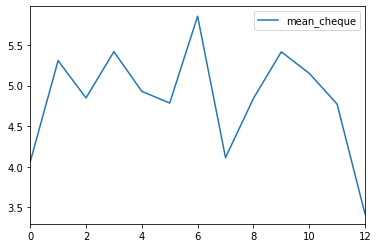

In [92]:
mean_cheque.plot(y='mean_cheque')

### 3.4. Расчет LTV по когортам.

In [93]:
orders.head()

,buy_ts,revenue,uid,buy_month,first_order_date,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,0


Рассчитаем количество пользователей в когортах.

In [94]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Рассчитаем выручку в когортах за каждый месяц.

In [95]:
LTV_cohorts = orders.groupby(['first_order_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
LTV_cohorts

,first_order_month,buy_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


Объединим данные о количестве пользователей и ежемесячной выручке в когортах.

In [96]:
report = cohort_sizes.merge(LTV_cohorts, on='first_order_month')
report

,first_order_month,n_buyers,buy_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Добавим данные о возрасте когорты.

In [97]:
report['age'] = (report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')

In [98]:
report['age'] = report['age'].round().astype('int')
report

,first_order_month,n_buyers,buy_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4
...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1
77,2018-05-01,2988,2018-05-01,13925.76,0


Рассчитаем ежемесячную выручку на одного пользователя в каждой когорте.

In [99]:
report['ltv'] = report['revenue'] / report['n_buyers']

Построим сводную таблицу со значениями ltv на одного пользователя в каждой когорте по каждому месяцу жизни когорты. Посчитаем выручку на одного пользователя каждой когорты за весь срок жизни когорты.

In [100]:
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').cumsum(axis=1).round(2)
output.fillna(' ')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


Построим тепловую карту.

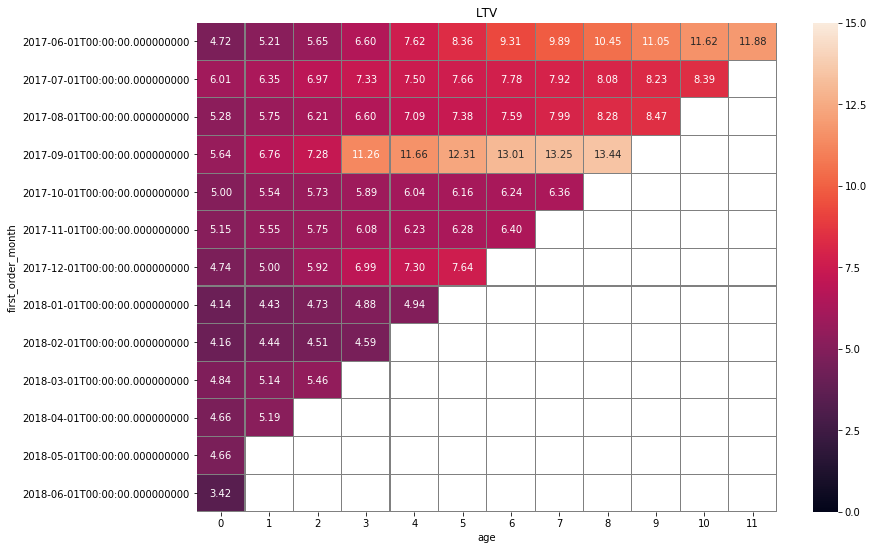

In [101]:
plt.figure(figsize=(13,9))
plt.title('LTV')
sns.heatmap(output, annot=True,fmt='.2f', linewidths=.1, linecolor='grey', vmin=0, vmax=15)

Из данных сводной таблицы и тепловой карты можно сделать следующие выводы: ожидаемо выручка с каждым месяцем жизни когорты снижается, на первом месяце жизни лучшие результаты показали когорты июля и сентября, сентябрьская когорта, прожив 8 месяцев, показала лучший результат по выручке, выручка за первый месяц снижается от начала к концу анализируемого периода. 

## Часть 4. Расчет метрик, характеризующих маркетинг

### Пункт 4.1. Расчет ROI.

In [102]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [103]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Рассчитаем ежемесячные затраты на маркетинг.

In [104]:
cost_per_month = costs.groupby('month')['costs'].sum().reset_index()
cost_per_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Добавим в таблицу report данные о ежемесячных затратах.

In [105]:
report_new = pd.merge(report, cost_per_month, left_on='first_order_month', right_on='month')

Рассчитаем затраты на одного пользователя в каждом месяце.

In [106]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new

,first_order_month,n_buyers,buy_month,revenue,age,ltv,month,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,2017-06-01,18015.00,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,2017-06-01,18015.00,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,2017-06-01,18015.00,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,2017-06-01,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1,0.300892,2018-03-01,30415.27,8.608907
74,2018-03-01,3533,2018-05-01,1114.87,2,0.315559,2018-03-01,30415.27,8.608907
75,2018-04-01,2276,2018-04-01,10600.69,0,4.657597,2018-04-01,22289.38,9.793225
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599,2018-04-01,22289.38,9.793225


Рассчитаем ROI как отношение ежемесячной выручки от одного пользователя к затратам на привлечение одного пользователя. 

In [107]:
report_new['roi'] = report_new['ltv'] / report_new['cac']

Посчитаем ROI с нарастающим итогом по месяцам жизни когорт.

In [108]:
output_new = report_new.pivot_table(index='first_order_month', columns='age', values='roi', aggfunc='mean')
output_new.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Рассчитаем среднюю ROI для всех когорт, чтобы узнать средний срок окупаемости привлечения покупателей.

In [109]:
output_new.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

Из вышеприведенных таблиц можно сделать следующие выводы. Средний срок окупаемости привлечения пользователя - 10 месяцев (средний ROI за 10 месяцев 1.094658). Июньская когорта окупилась за 6 месяцев (ROI за 6 месяцев 1.05). Чемпион по выручке - сентябрьская когорта - окупилась за 3 месяца (ROI за 3 месяца 1.19). Худший показатель у январской когорты - за 5 месяцев ROI достиг только 0,50. 

### Пункт 4.2. Расчет затрат по источникам привлечения и периодам.

Рассчитаем сколько денег всего было потрачено на каждый источник привлечения.

In [110]:
source_cost = costs.groupby('source_id')['costs'].sum()
source_cost

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Посчитаем сумму затрат по всем источникам за весь период. Рассчитаем долю каждого источника в общих затратах.

In [111]:
total_cost = source_cost.sum()
total_cost

329131.6199999999

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f92f7376f50>],
      dtype=object)

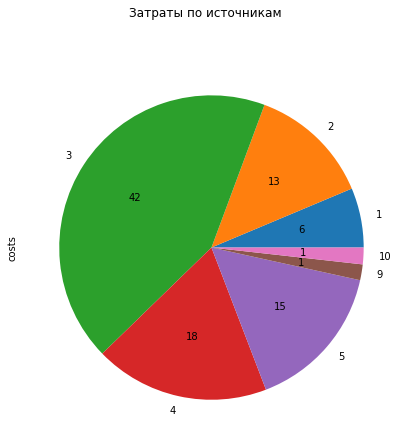

In [112]:
source_cost.plot.pie(subplots=True,figsize=(7,7),autopct='%d',title='Затраты по источникам')

Из вида диаграммы можно сделать вывод о неравномерном распределении затрат по источникам - на источник 3 было потрачено 42% от общего бюджета.

In [144]:
source_cost

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

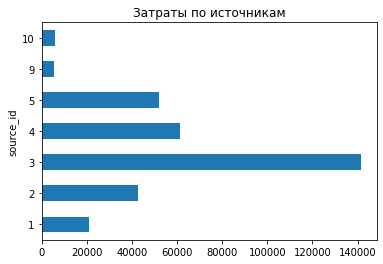

In [147]:
source_cost.plot(kind='barh',title='Затраты по источникам')

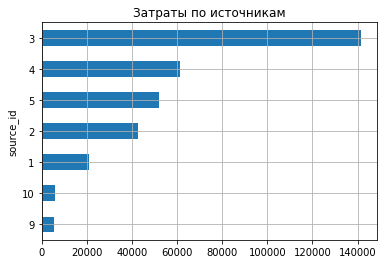

In [151]:
source_cost.sort_values(ascending=True).plot(kind='barh',title='Затраты по источникам')
plt.grid(True);

Построим график распределения общих затрат по месяцам.

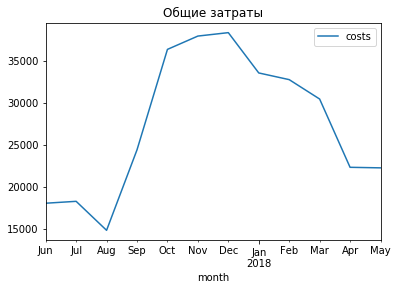

In [114]:
cost_per_month.plot(y='costs', x='month', title='Общие затраты')

По виду графика можно сделать вывод о том, что с августа по декабрь затраты на привлечение росли с каждым месяцем. С декабря по май затраты снижались.

Посчитаем как ежемесячные затраты были распределены по источникам.

In [115]:
cost_pivot = costs.pivot_table(index='month', columns='source_id',values='costs', aggfunc='sum')
cost_pivot

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


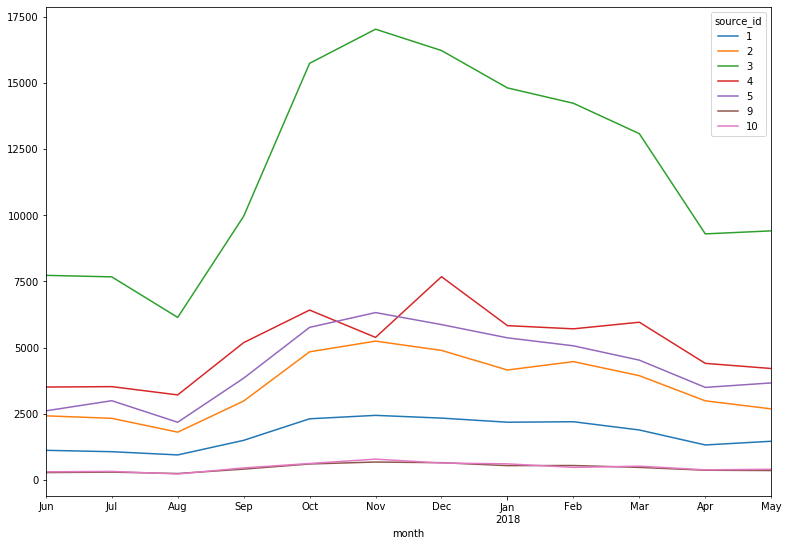

In [116]:
cost_pivot.plot(figsize=(13,9))

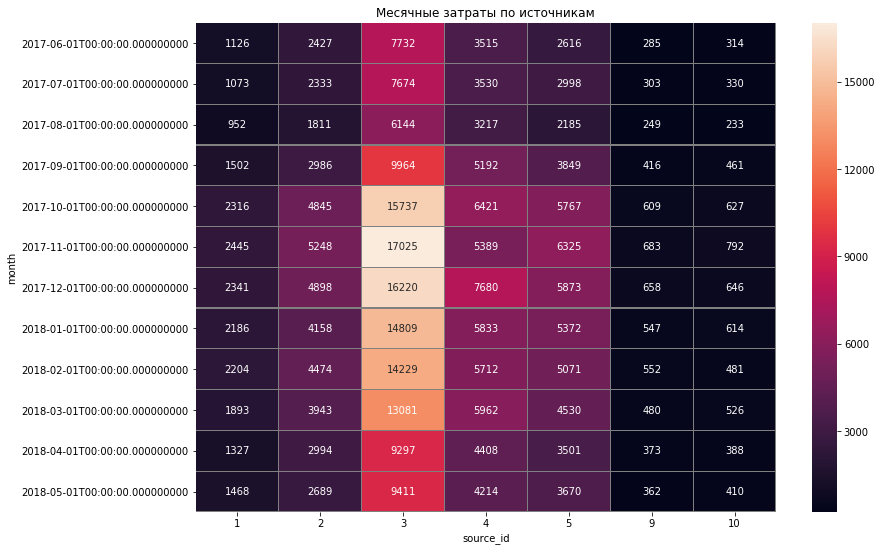

In [117]:
plt.figure(figsize=(13,9))
plt.title('Месячные затраты по источникам')
sns.heatmap(cost_pivot, annot=True,fmt='.0f', linewidths=.1, linecolor='grey')

Из вида привиденных выше графиков затрат по каждому источнику можно сделать вывод о том, что повышение затрат на привлечение, имевшее место с августа по декабрь, коснулось в основном вложений в источник 3, в незначительной мере в источники 4, 5 и 2, остальных источников не коснулось вовсе.

### 4.3. Расчет LTV, CAC, ROI и количества привлеченных пользователей для каждого источника.

Узнаем для каждого источника и каждого месяца выручку с одного пользователя, стоимость привлечения и количество пользователей, привлеченных из каждого источника. Считаем источником привлечения первый источник, с которого был осуществлен переход. Для этого объединим данные из таблиц visits, orders и costs.

In [118]:
first_source = visits.query('start_ts <= first_activity_date').loc[:,['uid','sourse_id','first_activity_month','device']]

In [119]:
first_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36523 entries, 1 to 97393
Data columns (total 4 columns):
uid                     36523 non-null uint64
sourse_id               36523 non-null int64
first_activity_month    36523 non-null datetime64[ns]
device                  36523 non-null object
dtypes: datetime64[ns](1), int64(1), object(1), uint64(1)
memory usage: 1.4+ MB


Проверим количество уникальных пользователей, полученное при объединении данных.

In [120]:
first_source['uid'].nunique()

36523

In [121]:
orders['uid'].nunique()

36523

In [122]:
orders = orders.merge(first_source, on = 'uid')

Рассчитаем количество привлеченных пользователей и выручку.

In [123]:
source_per_month_orders = orders.groupby(['sourse_id','first_activity_month']).agg({'uid':'nunique','revenue':'sum'}).reset_index()
source_per_month_orders.columns = ['source_id', 'month', 'n_buyers', 'revenue']
source_per_month_orders

,source_id,month,n_buyers,revenue
0,1,2017-06-01,240,9910.69
1,1,2017-07-01,184,2341.21
2,1,2017-08-01,126,2624.27
3,1,2017-09-01,248,2414.97
4,1,2017-10-01,350,3252.30
...,...,...,...,...
80,10,2018-01-01,103,369.68
81,10,2018-02-01,113,261.92
82,10,2018-03-01,166,545.28
83,10,2018-04-01,98,258.70


Рассчитаем затраты на каждый месяц по каждому источнику.

In [124]:
source_per_month_costs = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index() 
source_per_month_costs

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


In [125]:
source_per_month = source_per_month_orders.merge(source_per_month_costs, on=(['source_id','month']))
source_per_month

,source_id,month,n_buyers,revenue,costs
0,1,2017-06-01,240,9910.69,1125.61
1,1,2017-07-01,184,2341.21,1072.88
2,1,2017-08-01,126,2624.27,951.81
3,1,2017-09-01,248,2414.97,1502.01
4,1,2017-10-01,350,3252.30,2315.75
...,...,...,...,...,...
79,10,2018-01-01,103,369.68,614.35
80,10,2018-02-01,113,261.92,480.88
81,10,2018-03-01,166,545.28,526.41
82,10,2018-04-01,98,258.70,388.25


Рассчитаем и добавим в таблицу LTV, CAC и ROI.

In [126]:
source_per_month['ltv'] = source_per_month['revenue'] / source_per_month['n_buyers']

In [127]:
source_per_month['cac'] = source_per_month['costs'] / source_per_month['n_buyers']

In [128]:
source_per_month['roi'] = source_per_month['ltv'] / source_per_month['cac']

In [129]:
source_per_month

,source_id,month,n_buyers,revenue,costs,ltv,cac,roi
0,1,2017-06-01,240,9910.69,1125.61,41.294542,4.690042,8.804728
1,1,2017-07-01,184,2341.21,1072.88,12.723967,5.830870,2.182173
2,1,2017-08-01,126,2624.27,951.81,20.827540,7.554048,2.757136
3,1,2017-09-01,248,2414.97,1502.01,9.737782,6.056492,1.607826
4,1,2017-10-01,350,3252.30,2315.75,9.292286,6.616429,1.404426
...,...,...,...,...,...,...,...,...
79,10,2018-01-01,103,369.68,614.35,3.589126,5.964563,0.601742
80,10,2018-02-01,113,261.92,480.88,2.317876,4.255575,0.544668
81,10,2018-03-01,166,545.28,526.41,3.284819,3.171145,1.035847
82,10,2018-04-01,98,258.70,388.25,2.639796,3.961735,0.666323


Построим сводную таблицу и график зависимости LTV от месяца и источника привлечения.

In [130]:
ltv_per_source = source_per_month.pivot_table(index='month', columns='source_id', values='ltv', aggfunc='sum')
ltv_per_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,41.294542,20.819679,6.618172,14.894436,10.607171,7.191364,2.848496
2017-07-01,12.723967,10.700216,6.151549,6.022774,6.824637,6.759100,4.675082
2017-08-01,20.827540,7.111793,5.774116,5.746499,9.229130,5.479029,5.119556
2017-09-01,9.737782,15.452368,6.666487,5.641662,22.882809,7.908814,2.768958
2017-10-01,9.292286,11.288643,5.137043,4.931750,5.764804,4.492314,2.808909
2017-11-01,7.340514,9.558200,5.008528,5.440187,5.075355,4.220974,4.728043
2017-12-01,6.392409,39.005659,4.791237,4.415709,5.161511,4.558696,3.689600
2018-01-01,4.661396,8.103659,4.383983,4.001117,5.086329,3.340909,3.589126
2018-02-01,5.881772,6.819809,4.460672,4.518565,4.521686,4.862115,2.317876


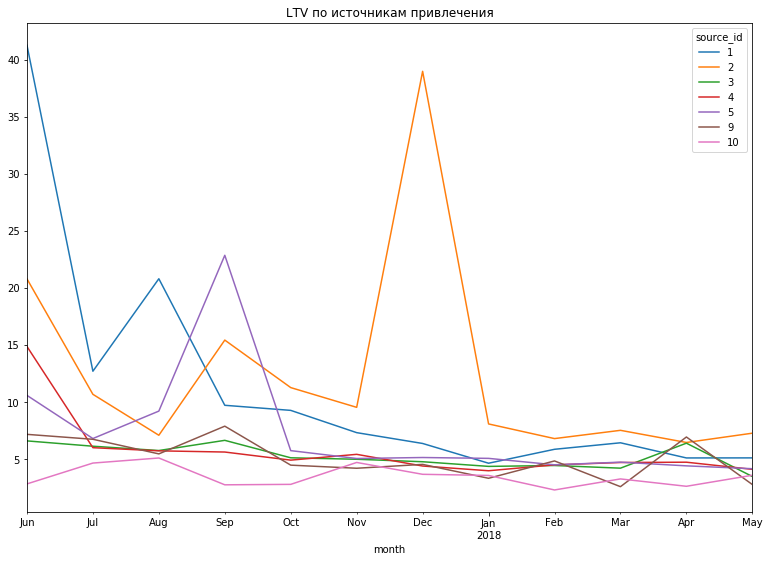

In [131]:
ltv_per_source.plot(figsize=(13,9), title='LTV по источникам привлечения')

Из графика можно сделать вывод о том, что наибольший LTV у пользователей, привлеченных из источников 5, 1 и 2. Чемпион по финансированию источник 3 показывает LTV ниже среднего. 

In [132]:
cac_per_source = source_per_month.pivot_table(index='month', columns='source_id', values='cac', aggfunc='sum')
cac_per_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,4.690042,6.490321,8.726467,5.432457,5.139725,1.852078,2.780708
2017-07-01,5.830870,8.392482,11.540406,5.236988,6.044637,3.025400,5.406885
2017-08-01,7.554048,12.490000,13.743937,7.715492,5.000641,2.416796,5.168222
2017-09-01,6.056492,11.224286,10.543439,7.438768,5.602824,3.522203,4.798646
2017-10-01,6.616429,11.535714,12.440506,5.016281,5.643249,5.036446,2.851091
2017-11-01,7.387190,12.768078,13.405780,4.203448,9.357012,4.436234,5.741739
2017-12-01,7.137805,14.664072,13.371410,5.949241,7.925128,7.151957,8.611467
2018-01-01,9.847658,16.901382,15.855225,5.976219,9.213585,9.948364,5.964563
2018-02-01,8.679055,17.077634,14.945966,6.025274,8.382331,10.605769,4.255575


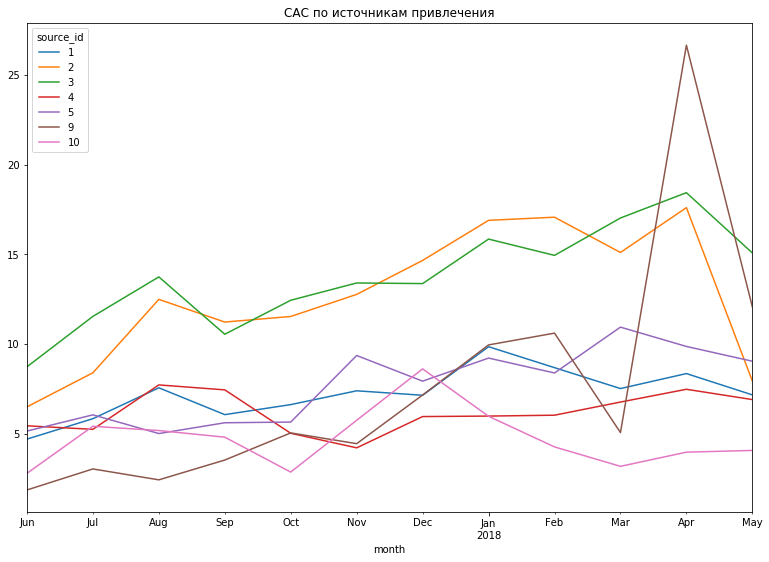

In [133]:
cac_per_source.plot(figsize=(13,9), title='CAC по источникам привлечения')

Из графика можно сделать вывод о том, что дороже всего привлечение одного пользователя (CAC) обходится из источников 2, 3 и 9.

Рассчитаем количество пользователей привлеченных из каждого источника.

In [134]:
number_per_source = source_per_month.pivot_table(index='month', columns='source_id', values='n_buyers', aggfunc='sum')
number_per_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,240,374,886,647,509,154,113
2017-07-01,184,278,665,674,496,100,61
2017-08-01,126,145,447,417,437,103,45
2017-09-01,248,266,945,698,687,118,96
2017-10-01,350,420,1265,1280,1022,121,220
2017-11-01,331,411,1270,1282,676,154,138
2017-12-01,328,334,1213,1291,741,92,75
2018-01-01,222,246,934,976,583,55,103
2018-02-01,254,262,952,948,605,52,113


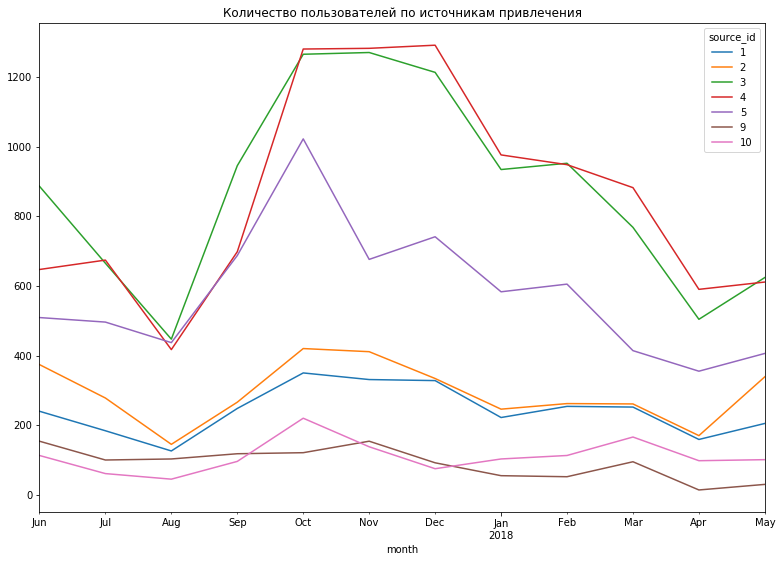

In [135]:
number_per_source.plot(figsize=(13,9), title='Количество пользователей по источникам привлечения')

Из графика можно сделать вывод о том, что наибольшее количество пользователей было привлечено из источников 3, 4 и 5.

Рассчитаем ROI для каждого источника.

In [136]:
roi_per_source = source_per_month.pivot_table(index='month', columns='source_id', values='roi', aggfunc='sum')
roi_per_source = roi_per_source.cumsum(axis=0).round(2)
roi_per_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,8.80,3.21,0.76,2.74,2.06,3.88,1.02
2017-07-01,10.99,4.48,1.29,3.89,3.19,6.12,1.89
2017-08-01,13.74,5.05,1.71,4.64,5.04,8.38,2.88
2017-09-01,15.35,6.43,2.34,5.40,9.12,10.63,3.46
2017-10-01,16.76,7.41,2.76,6.38,10.14,11.52,4.44
2017-11-01,17.75,8.16,3.13,7.67,10.69,12.47,5.27
2017-12-01,18.65,10.82,3.49,8.41,11.34,13.11,5.69
2018-01-01,19.12,11.30,3.77,9.08,11.89,13.45,6.30
2018-02-01,19.80,11.69,4.06,9.83,12.43,13.90,6.84


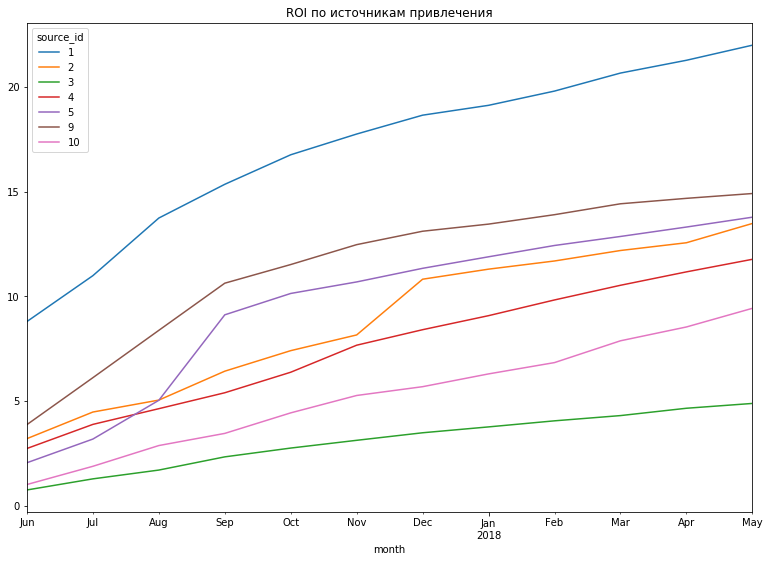

In [137]:
roi_per_source.plot(figsize=(13,9), title='ROI по источникам привлечения')

## 4.4. Расчет LTV и количества привлеченных пользователей для каждого вида устройств. 

Для каждого вида устройства, с которого был привлечен пользователь, рассчитаем LTV и количество пользователей, привлеченных c каждого вида устройства. Считаем источником привлечения первый источник, с которого был осуществлен переход. Для этого объединим данные из таблиц visits и orders.

In [138]:
device_per_month_orders = orders.groupby(['device','first_activity_month']).agg({'uid':'nunique','revenue':'sum'}).reset_index()
device_per_month_orders.columns = ['device', 'month', 'n_buyers', 'revenue']
device_per_month_orders

,device,month,n_buyers,revenue
0,desktop,2017-06-01,2387,35403.63
1,desktop,2017-07-01,1918,14083.05
2,desktop,2017-08-01,1390,10361.93
3,desktop,2017-09-01,2416,29243.29
4,desktop,2017-10-01,3800,22885.48
5,desktop,2017-11-01,3454,20153.92
6,desktop,2017-12-01,3276,27354.28
7,desktop,2018-01-01,2464,11893.38
8,desktop,2018-02-01,2484,12275.84
9,desktop,2018-03-01,2239,10872.78


In [139]:
device_per_month_orders['ltv'] = device_per_month_orders['revenue'] / device_per_month_orders['n_buyers']

In [140]:
ltv_device = device_per_month_orders.pivot_table(index='month', columns='device', values='ltv', aggfunc='sum')

Построим график для рассчитанных LTV каждого устройства. 

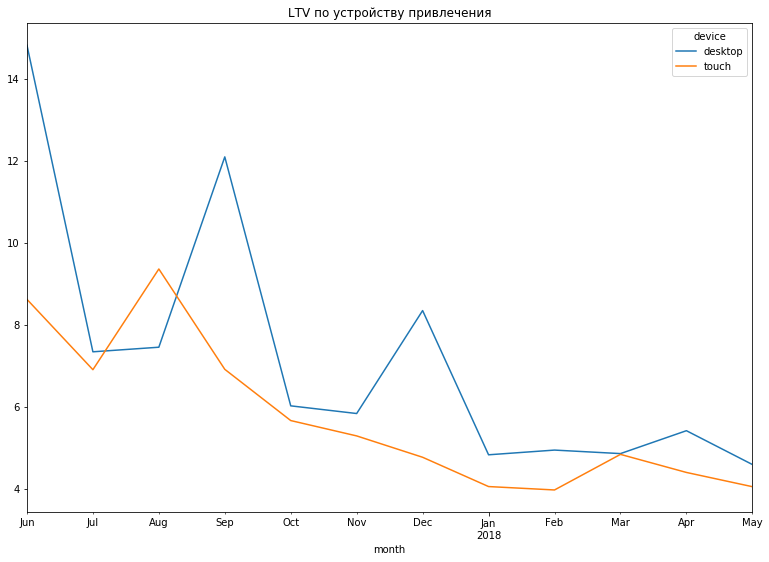

In [141]:
ltv_device.plot(figsize=(13,9), title='LTV по устройству привлечения')

По виду графика можно сделать вывод о том, что LTV устройства desktop выше, чем устройства touch, но с течением времени показатели обих устройств сближаются.

Построим график для количества пользователей, привлеченных с каждого вида устройств.

In [142]:
number_device = device_per_month_orders.pivot_table(index='month', columns='device', values='n_buyers', aggfunc='sum')

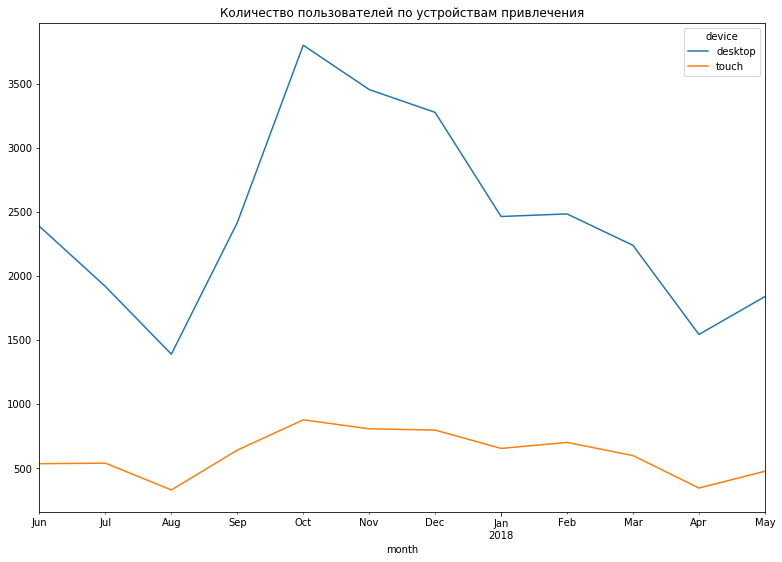

In [143]:
number_device.plot(figsize=(13,9), title='Количество пользователей по устройствам привлечения')

Из графика следует, что количество пользователей, привлеченных с устройства desktop в 3-4 раза превышает количество пользователей привлеченных с устройства touch. Сопоставив рассматриваемый график с графиками затрат на привлечение пользователей и количества привлеченных пользователей в зависимости от источника привлечения, можно предположить, что увеличение затрат, происходившее в период с августа по ноябрь, никак не сказалось на увеличении количества пользователей, привлеченных с устройства touch. Можно предположить, что средства, потраченные в большом объеме в указанный период были направлены на привлечение пользователей устройств desktop. 

# 5. Вывод.

Основываясь на вышеизложенном, маркетологам Яндекс.Афиша можно порекомендовать следующее. 
Перекос в затратах в пользу источника 3 (42% от общих затрат) нельзя назвать обоснованным. При наибольшем количестве привлеченных, LTV пользователей, пришедших из источника 3, ниже средних аналогичных показателей других источников. При этом стоимость привлечения одного пользователя из источника 3 одна из самых высоких для рассматриваемых источников, как следствие - один из самых низких ROI. 
Источник 4 (18% от общих затрат), при количестве привлеченных пользователей, сопоставимом с источником 3, имеет довольно низкий показатель ROI.
Источник 5 входит в топ-3 рассматриваемых источников по LTV, ROI и количеству привлеченных пользователей. Доля источника 5 в общих затратах составляет 15% (3 место), представляется возможным дальнейшее увеличение доли источника в общих затратах за счет источника 3, имеющего худшие сравнительные показатели.
Особенно перспективным представляется источник 1. Показатели LTV и ROI источника входят в топ-3, количество привлеченных пользователей находится в нижней трети рассматриваемых источников. Однако, доля источника в общих затратах составляет всего 6% от общих затрат и может быть ощутимо увеличена. 
Относительно платформы, с которой были привлечены пользователи, можно порекомендовать перераспределить бюджет в пользу мобильных устройств. При сопоставимых LTV, количество пользователей, привлеченных с мобильных устройств, в 3-4 раза ниже, чем с настольных. Можно предположить, что затраты на првлечение пользователей с мобильных устройств недостаточны. 